In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install albumentations -q

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from tqdm import tqdm
import kagglehub
import albumentations as A

SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/Covid_Project'
os.makedirs(SAVE_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")

# Use Lung Segmentation dataset
LUNG_DATA_DIR = os.path.join(path, "Lung Segmentation Data", "Lung Segmentation Data")

# Use the Infection Segmentation dataset
INF_DATA_DIR = os.path.join(path, "Infection Segmentation Data", "Infection Segmentation Data")

print(f"Lung Data: {LUNG_DATA_DIR}")
print(f"Infection Data: {INF_DATA_DIR}")


100%|██████████| 1.15G/1.15G [00:06<00:00, 196MB/s]

Extracting files...


Lung Data: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7/Lung Segmentation Data/Lung Segmentation Data
Infection Data: /root/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7/Infection Segmentation Data/Infection Segmentation Data


In [6]:
class CovidDataset(Dataset):
    def __init__(self, root_dir, phase='Train', mode='lung_pretrain', img_size=256, augmentation=None):
        """
        Args:
            root_dir: Path to dataset (LUNG_DATA_DIR or INF_DATA_DIR).
            mode: 'lung_pretrain' (Input=Raw, Target=Lung) or 'infection_finetune' (Input=ROI, Target=Infection).
        """
        self.mode = mode
        self.img_size = img_size
        self.augmentation = augmentation
        self.image_paths = []
        self.lung_mask_paths = []
        self.inf_mask_paths = []

        categories = ['COVID-19', 'Normal', 'Non-COVID']
        phase_dir = os.path.join(root_dir, phase)

        print(f"    [Loading {phase}] Source: {os.path.basename(root_dir)} | Mode: {mode} ")

        for cat in categories:
            cat_dir = os.path.join(phase_dir, cat)
            if not os.path.exists(cat_dir): continue

            # Get list of files
            imgs = sorted(glob.glob(os.path.join(cat_dir, "images", "*.png")))
            lungs = sorted(glob.glob(os.path.join(cat_dir, "lung masks", "*.png")))
            infs = sorted(glob.glob(os.path.join(cat_dir, "infection masks", "*.png")))

            if mode == 'lung_pretrain':
                # Only need Images and Lung Masks
                if len(imgs) == len(lungs) and len(imgs) > 0:
                    self.image_paths.extend(imgs)
                    self.lung_mask_paths.extend(lungs)
                    self.inf_mask_paths.extend([None] * len(imgs))
                    print(f"      {cat}: Loaded {len(imgs)} images")

            elif mode == 'infection_finetune':
                # Need all 3 files (Image, Lung Mask, Infection Mask).
                if len(imgs) == len(lungs) == len(infs) and len(imgs) > 0:
                    self.image_paths.extend(imgs)
                    self.lung_mask_paths.extend(lungs)
                    self.inf_mask_paths.extend(infs)
                    print(f"      {cat}: Loaded {len(imgs)} images")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        lung_mask = cv2.imread(self.lung_mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (self.img_size, self.img_size))
        lung_mask = cv2.resize(lung_mask, (self.img_size, self.img_size))

        _, lung_mask = cv2.threshold(lung_mask, 127, 255, cv2.THRESH_BINARY)

        if self.mode == 'lung_pretrain':
            if self.augmentation:
                augmented = self.augmentation(image=image, mask=lung_mask)
                image = augmented['image']
                lung_mask = augmented['mask']

            image = image.astype(np.float32) / 255.0
            lung_mask = (lung_mask > 127).astype(np.float32)  # Binary [0, 1]

            return (torch.from_numpy(np.expand_dims(image, 0)),
                    torch.from_numpy(np.expand_dims(lung_mask, 0)))

        elif self.mode == 'infection_finetune':
            inf_mask = cv2.imread(self.inf_mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            inf_mask = cv2.resize(inf_mask, (self.img_size, self.img_size))

            _, inf_mask = cv2.threshold(inf_mask, 127, 255, cv2.THRESH_BINARY)

            if self.augmentation:
                augmented = self.augmentation(image=image, masks=[inf_mask, lung_mask])
                image = augmented['image']
                inf_mask = augmented['masks'][0]
                lung_mask = augmented['masks'][1]

            image = image.astype(np.float32) / 255.0
            lung_mask = (lung_mask > 127).astype(np.float32)
            inf_mask = (inf_mask > 127).astype(np.float32)

            roi_image = image * lung_mask

            return (torch.from_numpy(roi_image[None, ...]),
                    torch.from_numpy(inf_mask[None, ...]))

In [7]:
def get_training_augmentation():
    return A.Compose([
        # Geometric transformations
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        # Intensity transformations
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        # Elastic deformation
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.3),
    ])

def get_validation_augmentation():
    return A.Compose([])

In [9]:
# U-NET
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
      return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, dropout=0.1):
        super(UNet, self).__init__()
        # Encoder (downsampling path)
        self.inc = DoubleConv(n_channels, 64, dropout)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128, dropout))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256, dropout))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512, dropout))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024, dropout))
        # Decoder (upsampling path)
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512, dropout)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256, dropout)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128, dropout)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64, dropout)

        # Output layer
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5); x = torch.cat([x, x4], dim=1); x = self.conv1(x)
        x = self.up2(x); x = torch.cat([x, x3], dim=1); x = self.conv2(x)
        x = self.up3(x); x = torch.cat([x, x2], dim=1); x = self.conv3(x)
        x = self.up4(x); x = torch.cat([x, x1], dim=1); x = self.conv4(x)
        return self.outc(x)

In [10]:
# Metrics and loss
class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
      super().__init__()
      self.bce_weight = bce_weight
      self.dice_weight = dice_weight

    def forward(self, inputs, targets, smooth=1e-5):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        inputs_sigmoid = torch.sigmoid(inputs)
        inputs_flat = inputs_sigmoid.view(inputs_sigmoid.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)
        intersection = (inputs_flat * targets_flat).sum(dim=1)
        dice_per_sample = (2. * intersection + smooth) / (
            inputs_flat.sum(dim=1) + targets_flat.sum(dim=1) + smooth
        )
        dice_loss = 1 - dice_per_sample.mean()

        # Weighted combination
        return self.bce_weight * bce + self.dice_weight * dice_loss

In [11]:
def calculate_metrics(pred, target, smooth=1e-5):
    pred = (torch.sigmoid(pred) > 0.5).float()
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    intersection = (pred_flat * target_flat).sum(dim=1)
    dice_per_sample = (2. * intersection + smooth) / (pred_flat.sum(dim=1) + target_flat.sum(dim=1) + smooth)

    union = pred_flat.sum(dim=1) + target_flat.sum(dim=1) - intersection
    iou_per_sample = (intersection + smooth) / (union + smooth)

    return dice_per_sample.mean().item(), iou_per_sample.mean().item()

In [12]:
# Training
def run_training(model, train_loader, val_loader, epochs, lr, save_name, use_focal=False):
    criterion = DiceBCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
    best_dice = 0.0
    print(f"\n    Start Training: {save_name}")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_dice = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
            with torch.no_grad():
              d, _ = calculate_metrics(outputs, masks)
              train_dice += d

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = train_dice / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_dice = 0
        val_iou = 0
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]  ", leave=False):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                d, i = calculate_metrics(outputs, masks)
                val_dice += d
                val_iou += i

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}")
        print(f"  Val   - Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, IoU: {avg_val_iou:.4f}")

        scheduler.step(avg_val_dice)

        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            torch.save(model.state_dict(), os.path.join(SAVE_DIR, save_name))
            print(f"   [Saved Best Model: {best_dice:.4f}]")

In [ ]:
# Lung segmentation
train_ds1 = CovidDataset(LUNG_DATA_DIR, phase='Train', mode='lung_pretrain', img_size=256, augmentation=get_training_augmentation())
val_ds1 = CovidDataset(LUNG_DATA_DIR, phase='Val', mode='lung_pretrain', img_size=256, augmentation=None)

train_loader1 = DataLoader(train_ds1, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader1 = DataLoader(val_ds1, batch_size=32, num_workers=2, pin_memory=True)

model = UNet(n_channels=1, n_classes=1, dropout=0.1).to(device)
run_training(model, train_loader1, val_loader1, epochs=5, lr=1e-3, save_name='lung_model.pth')

    [Loading Train] Source: Lung Segmentation Data | Mode: lung_pretrain 
      COVID-19: Loaded 7658 images
      Normal: Loaded 6849 images
      Non-COVID: Loaded 7208 images
    [Loading Val] Source: Lung Segmentation Data | Mode: lung_pretrain 
      COVID-19: Loaded 1903 images
      Normal: Loaded 1712 images
      Non-COVID: Loaded 1802 images

    Start Training: lung_model.pth


Epoch 1/5 [Train]: 100%|██████████| 679/679 [18:26<00:00,  1.63s/it, loss=0.0574]



Epoch 1/5
  Train - Loss: 0.1660, Dice: 0.8651
  Val   - Loss: 0.0596, Dice: 0.9516, IoU: 0.9101
   [Saved Best Model: 0.9516]


Epoch 2/5 [Train]: 100%|██████████| 679/679 [18:28<00:00,  1.63s/it, loss=0.0480]



Epoch 2/5
  Train - Loss: 0.0715, Dice: 0.9411
  Val   - Loss: 0.0411, Dice: 0.9655, IoU: 0.9349
   [Saved Best Model: 0.9655]


Epoch 3/5 [Train]: 100%|██████████| 679/679 [18:28<00:00,  1.63s/it, loss=0.0477]



Epoch 3/5
  Train - Loss: 0.0632, Dice: 0.9477
  Val   - Loss: 0.0379, Dice: 0.9687, IoU: 0.9405
   [Saved Best Model: 0.9687]


Epoch 4/5 [Train]: 100%|██████████| 679/679 [18:26<00:00,  1.63s/it, loss=0.0404]



Epoch 4/5
  Train - Loss: 0.0587, Dice: 0.9514
  Val   - Loss: 0.0357, Dice: 0.9702, IoU: 0.9433
   [Saved Best Model: 0.9702]


Epoch 5/5 [Train]: 100%|██████████| 679/679 [18:24<00:00,  1.63s/it, loss=0.0521]
                                                                    


Epoch 5/5
  Train - Loss: 0.0575, Dice: 0.9524
  Val   - Loss: 0.0371, Dice: 0.9692, IoU: 0.9416


In [ ]:
# Infection Segmentation
train_ds2 = CovidDataset(INF_DATA_DIR, 'Train', 'infection_finetune', img_size=256, augmentation=get_training_augmentation())
val_ds2 = CovidDataset(INF_DATA_DIR, 'Val', 'infection_finetune', img_size=256, augmentation=None )

train_loader2 = DataLoader(train_ds2, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader2 = DataLoader(val_ds2, batch_size=32, num_workers=2, pin_memory=True)

model_v2 = UNet(n_channels=1, n_classes=1, dropout=0.1).to(device)
lung_model_path = os.path.join(SAVE_DIR, 'lung_model.pth')

if os.path.exists(lung_model_path):
    model_v2.load_state_dict(torch.load(lung_model_path))
    print("   Successfully loaded Lung Model weights.")
else:
    print("   Warning: Lung Model not found! Training from scratch.")

run_training(model_v2, train_loader2, val_loader2, epochs=30, lr=1e-4, save_name='infection_final.pth')

In [15]:
test_lung_ds = CovidDataset(LUNG_DATA_DIR, phase='Test', mode='lung_pretrain', img_size=256, augmentation=None)
test_lung_loader = DataLoader(test_lung_ds, batch_size=1, shuffle=False)

best_lung_model = UNet(n_channels=1, n_classes=1).to(device)
best_lung_model_path = os.path.join(SAVE_DIR, 'lung_model.pth')

criterion = DiceBCELoss().to(device)

if os.path.exists(best_lung_model_path):
    best_lung_model.load_state_dict(torch.load(best_lung_model_path))
    best_lung_model.eval()
    print("  Best LUNG Model loaded.")
else:
    print("  Error: Lung Model file not found.")

lung_dice_scores = []
lung_iou_scores = []
lung_test_losses = []

print(f"Testing Lung Model on {len(test_lung_ds)} images...")
with torch.no_grad():
    for img, mask in tqdm(test_lung_loader):
        img, mask = img.to(device), mask.to(device)

        output = best_lung_model(img)

        loss = criterion(output, mask)
        lung_test_losses.append(loss.item())

        d, i = calculate_metrics(output, mask)
        lung_dice_scores.append(d)
        lung_iou_scores.append(i)

print(f"Mean Loss       : {np.mean(lung_test_losses):.4f}")
print(f"Mean Dice Score : {np.mean(lung_dice_scores):.4f}")
print(f"Mean IoU Score  : {np.mean(lung_iou_scores):.4f}")

    [Loading Test] Source: Lung Segmentation Data | Mode: lung_pretrain 
      COVID-19: Loaded 2395 images
      Normal: Loaded 2140 images
      Non-COVID: Loaded 2253 images
  Best LUNG Model loaded.
Testing Lung Model on 6788 images...


100%|██████████| 6788/6788 [02:43<00:00, 41.64it/s]

Mean Loss       : 0.0372
Mean Dice Score : 0.9690
Mean IoU Score  : 0.9411


In [ ]:
# Evaluation
test_ds = CovidDataset(INF_DATA_DIR, phase='Test', mode='infection_finetune', img_size=256, augmentation=None)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

best_model = UNet(n_channels=1, n_classes=1).to(device)
best_model_path = os.path.join(SAVE_DIR, 'infection_final.pth')

criterion = DiceBCELoss().to(device)

if os.path.exists(best_model_path):
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()
    print("   Best Hybrid Model loaded.")
else:
    print("   Error: Model file not found.")

dice_scores = []
iou_scores = []
test_losses = []

print(f"Testing on {len(test_ds)} images...")
with torch.no_grad():
    for img, mask in tqdm(test_loader):
        img, mask = img.to(device), mask.to(device)
        output = best_model(img)
        loss = criterion(output, mask)
        test_losses.append(loss.item())
        d, i = calculate_metrics(output, mask)
        dice_scores.append(d)
        iou_scores.append(i)

print(f"Mean Loss       : {np.mean(test_losses):.4f}")
print(f"Mean Dice Score : {np.mean(dice_scores):.4f}")
print(f"Mean IoU Score  : {np.mean(iou_scores):.4f}")

    [Loading Test] Source: Infection Segmentation Data | Mode: infection_finetune 
      COVID-19: Loaded 583 images
      Normal: Loaded 291 images
      Non-COVID: Loaded 292 images
   Best Hybrid Model loaded.
Testing on 1166 images...


100%|██████████| 1166/1166 [00:44<00:00, 26.19it/s]

Mean Loss       : 0.3656
Mean Dice Score : 0.6167
Mean IoU Score  : 0.5642


Visualizing random samples:


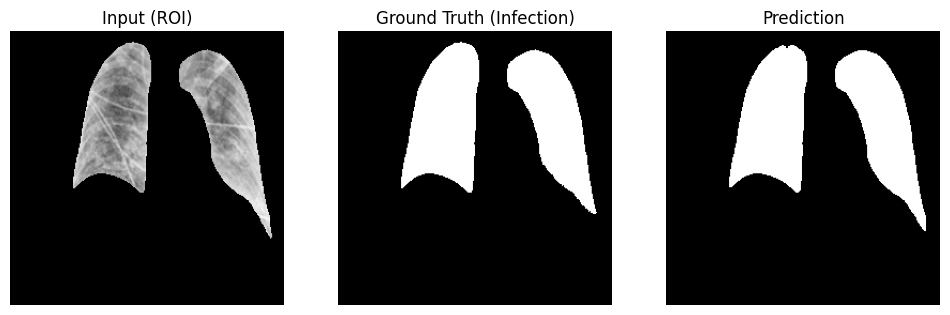

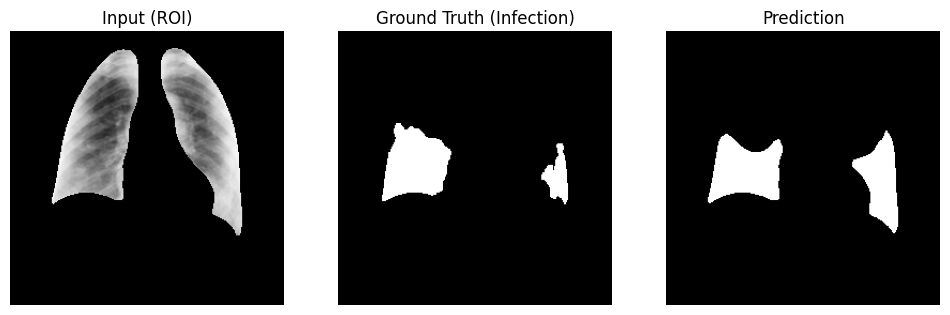

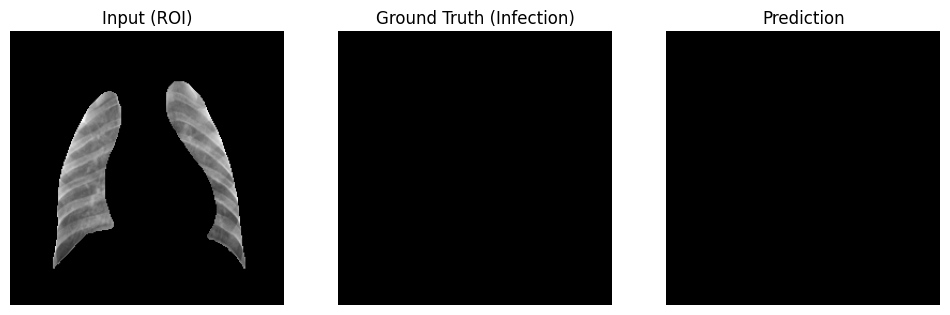

In [ ]:
# Visualization
def show_sample():
    idx = np.random.randint(0, len(test_ds))
    img, mask = test_ds[idx]

    # Predict
    input_tensor = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_logits = best_model(input_tensor)
        pred_mask = (torch.sigmoid(pred_logits) > 0.5).float()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title("Input (ROI)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth (Infection)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.cpu().squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

print("Visualizing random samples:")
show_sample()
show_sample()
show_sample()